In [1]:
!pip install open3d numpy matplotlib scipy scikit-learn


Defaulting to user installation because normal site-packages is not writeable


In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d

from scipy.spatial import Delaunay
from scipy.interpolate import griddata  # For interpolation
from sklearn.neighbors import KDTree
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Load DSM and Plane Data

In [5]:
try:
    with open("dsm.json") as f:
        dsm_data = np.array(json.load(f))
        print("DSM data successfully loaded.")
except FileNotFoundError:
    print("Error: DSM file not found.")
    exit()

try:
    with open("planes.json") as f:
        planes_data = json.load(f)
        print("Planes data successfully loaded.")
except FileNotFoundError:
    print("Error: Planes file not found.")
    exit()

DSM data successfully loaded.
Planes data successfully loaded.


## Create Point Cloud

In [6]:
points = dsm_data[:, :3]
print(f"Number of points in point cloud: {len(points)}")

# Create point cloud with Open3D
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

# Assign colors based on height
colors = plt.cm.viridis(
    (points[:, 2] - points[:, 2].min()) / (points[:, 2].ptp())
)
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])

Number of points in point cloud: 9746


## Process Planes and Create Meshes

In [7]:
meshes = []
all_mesh_vertices = []

for plane_index, plane in enumerate(planes_data):
    # Get perimeter points
    perimeter = np.array(
        [[p['x'], p['y'], plane['height']] for p in plane['perimeter']]
    )
    noise = np.random.normal(0, 1e-6, perimeter.shape)
    perimeter_noisy = perimeter + noise

    # Create mesh with Delaunay triangulation
    tri = Delaunay(perimeter_noisy[:, :2])
    triangles = tri.simplices

    # Create mesh
    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(perimeter_noisy)
    mesh.triangles = o3d.utility.Vector3iVector(triangles)
    mesh.compute_vertex_normals()
    meshes.append(mesh)

    # Collect all mesh vertices
    all_mesh_vertices.append(perimeter_noisy)

## Accuracy Analysis

Total number of points in meshes: 10


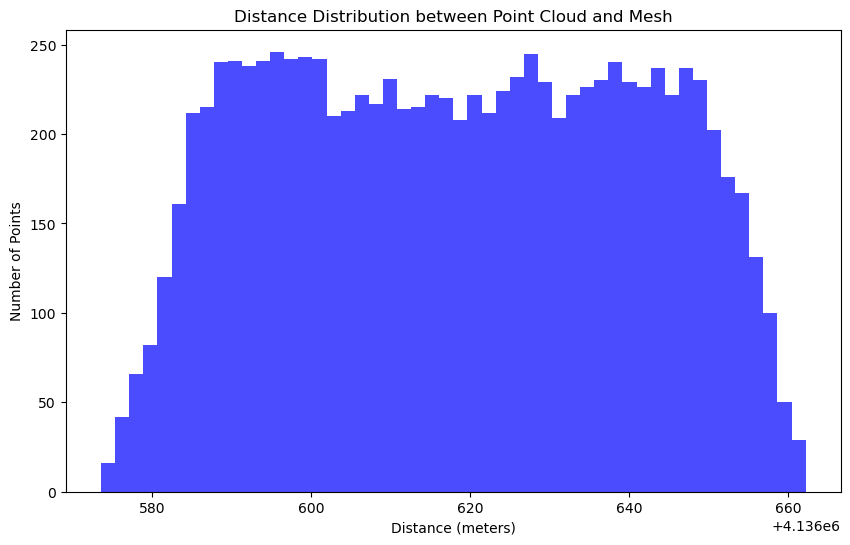

Mean distance: 4136618.3827 meters
Maximum distance: 4136662.1851 meters


In [8]:
# Combine all mesh points
mesh_points = np.vstack(all_mesh_vertices)
print(f"Total number of points in meshes: {len(mesh_points)}")

# Compute nearest distances using KDTree
tree = KDTree(mesh_points)
distances, _ = tree.query(points[:, :3], k=1)

# Distance histogram
plt.figure(figsize=(10, 6))
plt.hist(distances, bins=50, color='blue', alpha=0.7)
plt.title('Distance Distribution between Point Cloud and Mesh')
plt.xlabel('Distance (meters)')
plt.ylabel('Number of Points')
plt.show()

# Mean and maximum distance
mean_distance = np.mean(distances)
max_distance = np.max(distances)
print(f"Mean distance: {mean_distance:.4f} meters")
print(f"Maximum distance: {max_distance:.4f} meters")

## point Cloud and Mesh Visualization (2D)

Creating 2D visualization...


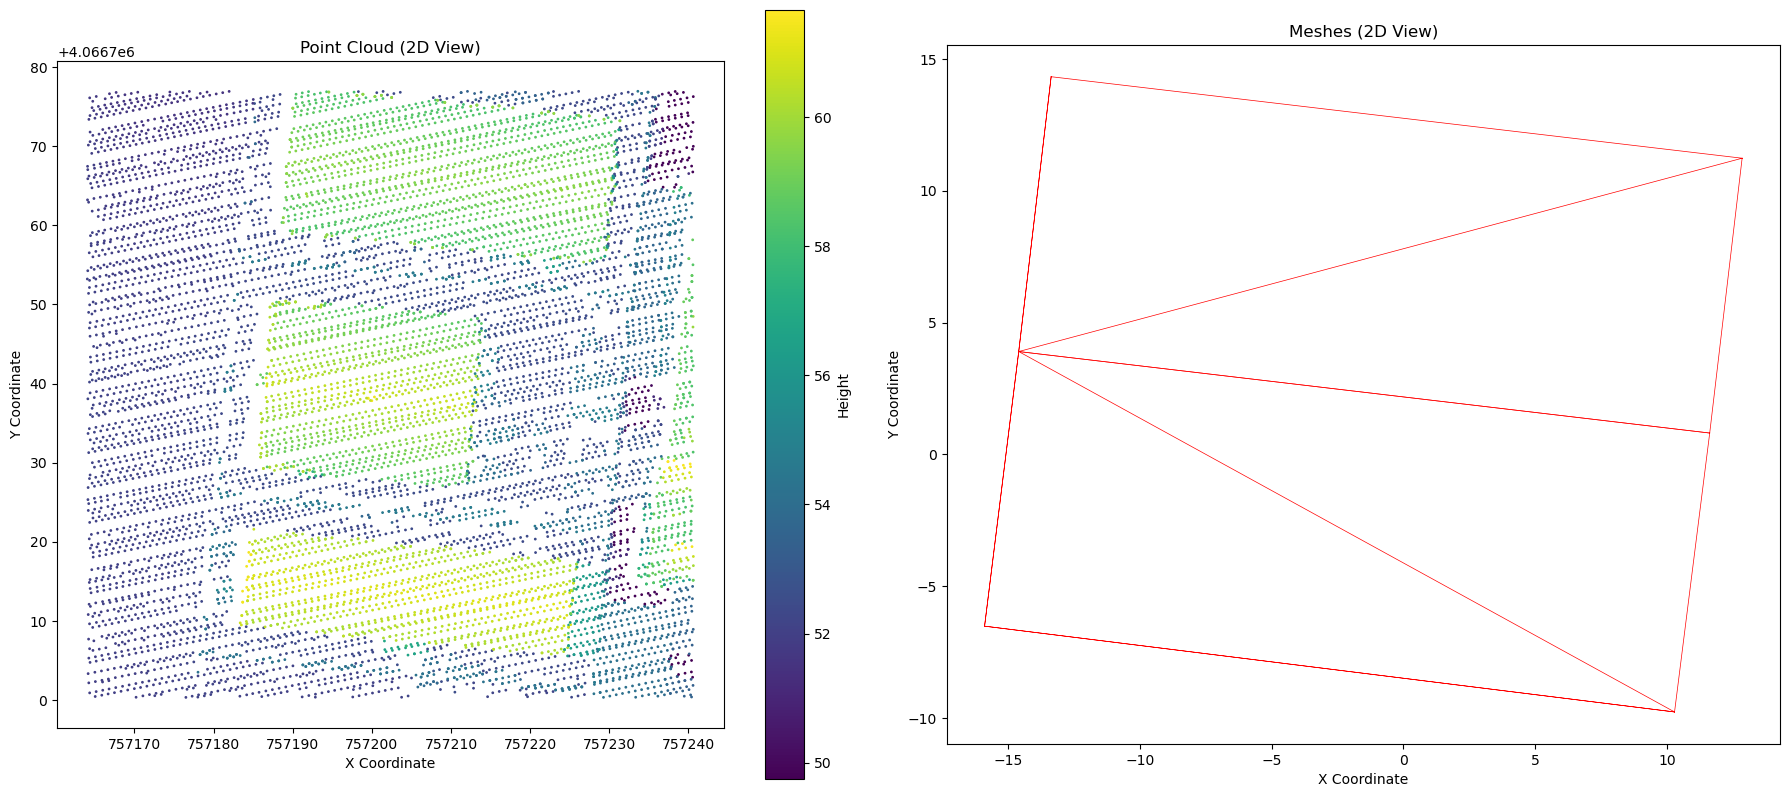

In [9]:
print("Creating 2D visualization...")

fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# Point Cloud 2D Visualization
scatter = axs[0].scatter(points[:, 0], points[:, 1], c=points[:, 2], cmap='viridis', s=1)
axs[0].set_title('Point Cloud (2D View)')
axs[0].set_xlabel('X Coordinate')
axs[0].set_ylabel('Y Coordinate')
axs[0].set_aspect('equal')
fig.colorbar(scatter, ax=axs[0], label='Height')

# Meshes 2D Visualization
for mesh in meshes:
    vertices = np.asarray(mesh.vertices)
    triangles = np.asarray(mesh.triangles)
    axs[1].triplot(vertices[:, 0], vertices[:, 1], triangles, color='red', linewidth=0.5)
axs[1].set_title('Meshes (2D View)')
axs[1].set_xlabel('X Coordinate')
axs[1].set_ylabel('Y Coordinate')
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()


## Height Distribution Histogram , 2D Contour Plot , 3D Surface Plot

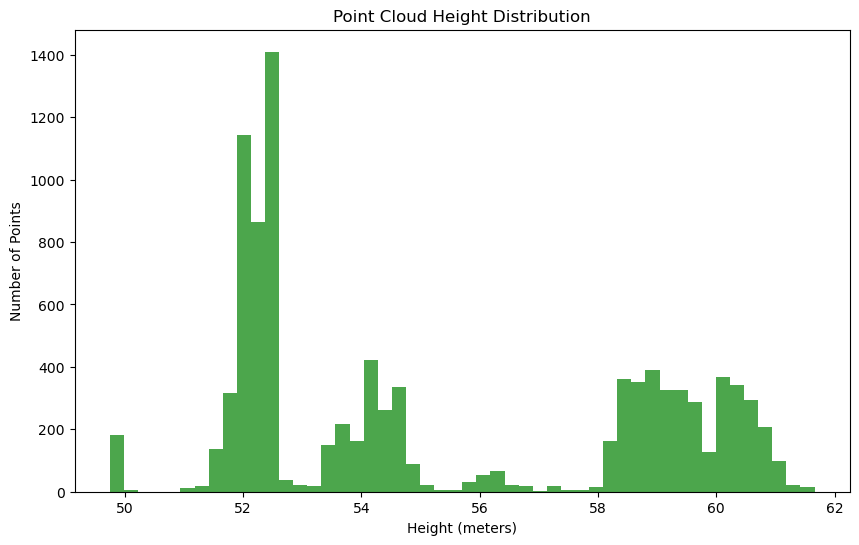

Creating 2D contour plot...


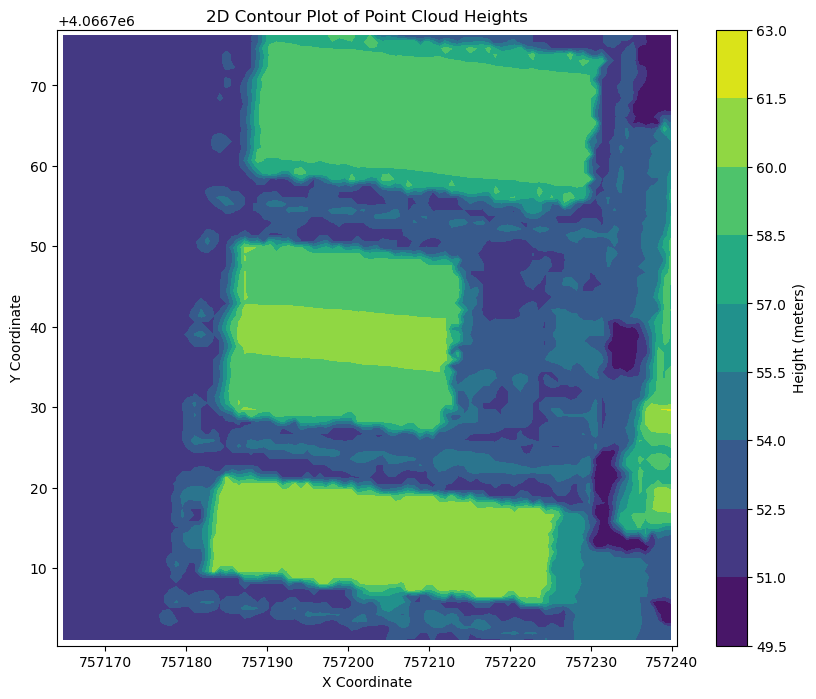

Creating 3D surface plot...


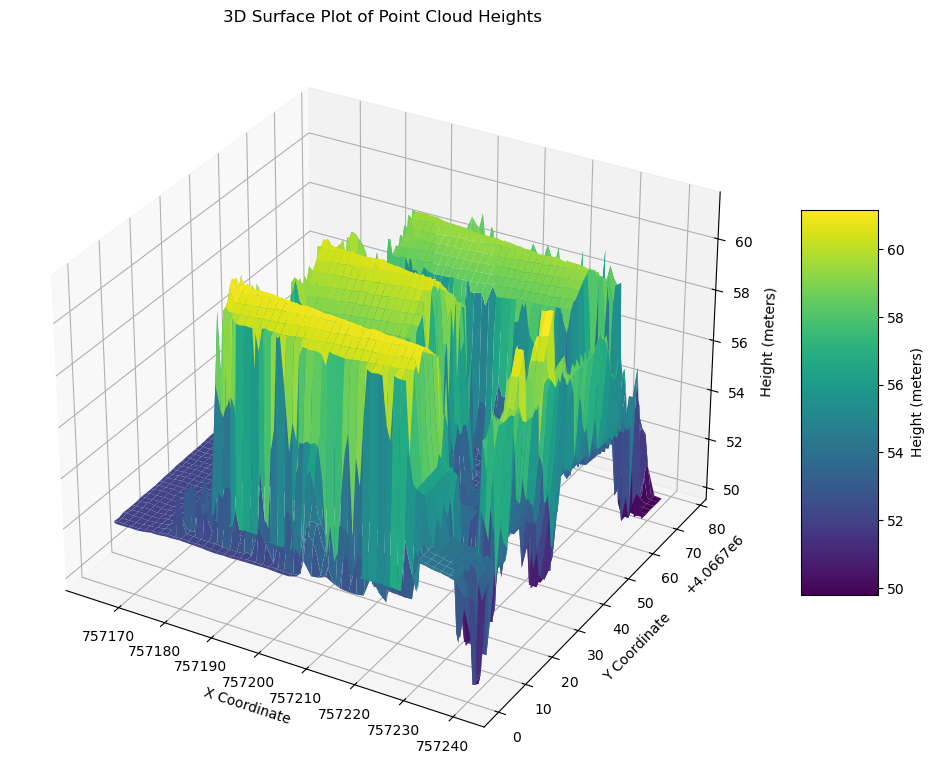

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(points[:, 2], bins=50, color='green', alpha=0.7)
plt.title('Point Cloud Height Distribution')
plt.xlabel('Height (meters)')
plt.ylabel('Number of Points')
plt.show()

print("Creating 2D contour plot...")

# Create grid values first
numgrid = 100  # You can adjust this value for grid resolution
xi = np.linspace(points[:, 0].min(), points[:, 0].max(), numgrid)
yi = np.linspace(points[:, 1].min(), points[:, 1].max(), numgrid)
xi, yi = np.meshgrid(xi, yi)

# Interpolate Z values onto grid
zi = griddata((points[:, 0], points[:, 1]), points[:, 2], (xi, yi), method='linear')

# Plot contour
plt.figure(figsize=(10, 8))
cp = plt.contourf(xi, yi, zi, cmap='viridis')
plt.colorbar(cp, label='Height (meters)')
plt.title('2D Contour Plot of Point Cloud Heights')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

print("Creating 3D surface plot...")

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(xi, yi, zi, cmap='viridis', edgecolor='none')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Height (meters)')
ax.set_title('3D Surface Plot of Point Cloud Heights')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Height (meters)')
plt.show()